In [1]:
import numpy as np
from joblib import load
from pathlib import Path
from xspec import AllModels, AllData, Model, Plot
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from modules.network import r_squared

2024-01-17 09:52:09.763038: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 09:52:09.988851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 09:52:09.988890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 09:52:10.029698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 09:52:10.110511: I tensorflow/core/platform/cpu_feature_guar

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
Compton reflection from ionized medium.
If you use results from this model in a paper
please refer to Chris Done

Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdb

Text(0.5, 0, 'Energy (KeV)')

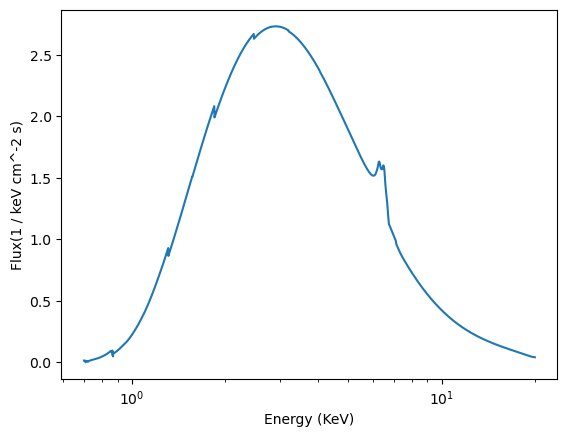

In [2]:
# Clear existing XSPEC models and data
AllModels.clear()
AllData.clear()
AllData.dummyrsp(0.7 ,20.)

# Create the model
model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"
true_model = Model(model_name)

# Changing default frozen parameters to unfrozen
true_model.rdblur.Betor10.frozen = False
true_model.rdblur.Rout_M.frozen = True
true_model.rdblur.Rin_M.frozen = False
true_model.rfxconv.Fe_abund.frozen = False
true_model.comptb.gamma.frozen = True
true_model.comptb.delta.frozen = True
true_model.comptb.log_A.frozen = True

true_model.rdblur.Rout_M.values = 1000
true_model.comptb.log_A.values = 8

# Linking the parameters
true_model.rfxconv.cosIncl.link = "COSD(5)"

start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(true_model.comptb_6.parameterNames)):
    true_model(i).link = true_model(i-9) # 9 is the separation between comptb and comptb_6

# Collect the relevant parameter (the ones not frozen or linked)
relevant_par = []
for n_par in range(1, true_model.nParameters + 1):
    if not true_model(n_par).frozen and not true_model(n_par).link:
        relevant_par.append(n_par)


# Set up the energy range of interest for plotting
Plot.device = "/null"
Plot.xAxis = "keV"
Plot.show()
Plot('model')
energy = Plot.x()
true_flux = Plot.model()

plt.plot(energy, true_flux)
plt.xscale("log")
plt.ylabel("Flux(1 / keV cm^-2 s)")
plt.xlabel("Energy (KeV)")


In [3]:
for n_par in range(1, true_model.nParameters + 1):
    if not true_model(n_par).frozen and not true_model(n_par).link:
        print(true_model(n_par).values)


[1.0, 0.01, 0.0, 0.0, 100000.0, 1000000.0]
[-2.0, 0.02, -10.0, -10.0, 20.0, 20.0]
[10.0, 0.1, 6.0, 6.0, 1000.0, 10000.0]
[30.0, 0.3, 0.0, 0.0, 90.0, 90.0]
[-1.0, 0.01, -1.0, -1.0, 1000000.0, 1000000.0]
[1.0, 0.01, 0.5, 0.5, 3.0, 3.0]
[1.0, 0.01, 1.0, 1.0, 6.0, 6.0]
[1.0, 0.01, 0.1, 0.1, 10.0, 10.0]
[2.0, 0.02, 0.0, 0.0, 400.0, 400.0]
[5.0, 0.05, 0.2, 0.2, 2000.0, 2000.0]
[1.0, 0.01, 0.0, 0.0, 1e+20, 1e+24]
[1.0, 0.01, 0.0, 0.0, 1000.0, 1000.0]
[1.0, 0.01, 0.0, 0.0, 1e+20, 1e+24]


In [4]:
path_to_logs = Path(Path.cwd() / 'logs')
log_dir = path_to_logs / 'fit' / 'ANN_512x5_150e'
model_file_path = log_dir / 'my_model.h5'

# Load the model
model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
X_scaler = load(log_dir / 'X_scaler.joblib')
X_new_scaled = X_scaler.transform([true_flux])

# Make predictions
prediction = model.predict(X_new_scaled)
# Load the scalers
loaded_scalers = {}
parameters = []
for i in range(prediction.shape[1]):
    loaded_scalers[i] = load(log_dir / f'scaler_{i}.joblib')
    parameters.append(loaded_scalers[i].inverse_transform(prediction[0][i].reshape(-1,1)))
# Extracting the single float value from each sub-array
par = np.array([arr[0, 0] for arr in parameters]).astype(float)
log_index = [0, 2, 7, 9, 10, 11, 12]
for i in log_index:
    par[i] =  pow(10, par[i])

2024-01-17 09:52:13.393964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 09:52:13.520129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 09:52:13.520174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 09:52:13.521912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 09:52:13.521951: I external/local_xla/xla/stream_executor

1/1 [==============================] - 0s 240ms/step


2024-01-17 09:52:14.650941: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-01-17 09:52:14.650973: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-01-17 09:52:14.651011: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-17 09:52:14.690117: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.



Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.00000      frozen
  13    4   comptb     al

Text(0.5, 0, 'Energy (KeV)')

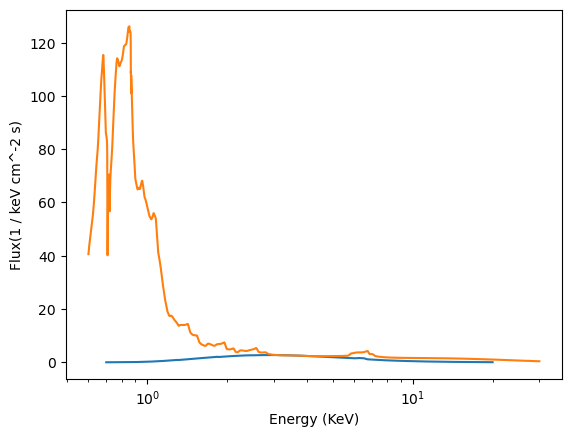

In [5]:
# Clear existing XSPEC models and data
AllModels.clear()
AllData.clear()
AllData.dummyrsp(0.6 ,30.)

# Create the model
model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"
# Initialize the model with the scaled parameters
#m = Model(model_name)
m = Model(model_name, setPars={int(relevant_par[j]):par[j] for j in range(len(relevant_par))})

# Changing default frozen parameters to unfrozen
m.rdblur.Betor10.frozen = False
m.rdblur.Rout_M.frozen = True
m.rdblur.Rin_M.frozen = False
m.rfxconv.Fe_abund.frozen = False
m.comptb.gamma.frozen = True
m.comptb.delta.frozen = True
m.comptb.log_A.frozen = True

m.rdblur.Rout_M.values = 1000
m.comptb.log_A.values = 8

'''
#m(1).values = par[0]
m(2).values = 0#par[1]
m(3).values = 20#par[2]
m(5).values = 60#par[3]
#m(6).values = par[4]
#m(8).values = par[5]
#m(10).values = par[6]
#m(11).values = 5#par[7]
#m(13).values = par[8]
m(15).values = 10#par[9]
#m(17).values = par[10]
#m(18).values = par[11]
#m(19).values = par[12]
'''
m.rfxconv.cosIncl.link = "COSD(5)"
# Linking comptb_6 (refletion) parameters to comptb (comptb)
start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(m.comptb_6.parameterNames)):
    m(i).link = m(i-9) # 9 is the separation between comptb and comptb_6

# Add the model to the spectral analysis system
AllModels.setPars(m)

# Set up the energy range of interest for plotting
Plot.device = "/null"
Plot.xAxis = "keV"
Plot.show()
Plot('model')
m_energy = Plot.x()
m_flux = Plot.model()

plt.plot(energy, true_flux, label="True")
plt.plot(m_energy, m_flux, label="Model")
plt.xscale("log")
plt.ylabel("Flux(1 / keV cm^-2 s)")
plt.xlabel("Energy (KeV)")

In [6]:
par

array([ 0.26330611, -5.30554533, 67.10677556, 42.36237335, -0.52969557,
        1.68366265,  2.41373682,  4.76715422,  1.40932333, 57.98274209,
        7.51668468,  0.76296748,  7.32482468])

In [7]:
m(19).values

[7.324824684084026, 0.07324824684084026, 0.0, 0.0, 1e+20, 1e+24]

In [8]:
m.show()


Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    0.263306     +/-  0.0          
   2    2   rdblur     Betor10             -5.30555     +/-  0.0          
   3    2   rdblur     Rin_M               67.1068      +/-  0.0          
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      42.3624      +/-  0.0          
   6    3   rfxconv    rel_refl            -0.529696    +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.68366      +/-  0.0          
   9    3   rfxconv    cosIncl             0.738898     = COSD(p5)
  10    3   rfxconv    log_xi              2.41374      +/-  0.0          
  11    4   comptb     kTs        keV      4.76715      +/-  0.0          
  12    4   comptb     gamma               3.000